In [1]:
import numpy as np
import os
import pandas as pd
import sys
sys.path.append("../")
from importlib import reload
import matplotlib.pyplot as plt
import torch
from PIL import Image
from torchvision.transforms import ToTensor, ToPILImage
from bdd100k.label.palette import get_palette
import json
from prettytable.prettytable import PrettyTable

from lib.data.tools import load_mmcv_checkpoint, load_checkpoint
from models.modelInterface import BDD100kModel
from lib.utils.dbhandler import JsonDBHandler, Items, ConditionClassItem
import lib.utils.visual
reload(lib.utils.visual)
from lib.utils.visual import generate_graph
from lib.utils.dbhandler import JsonDBHandler
from lib.simulation.env import get_transforms

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"


/home/zekun/drivable/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/zekun/drivable/.venv/lib/python3.10/site-packages/torchvision/datapoints/__init__.py:12: UserWarning: The torchvision.datapoints and torchvision.transforms.v2 namespaces are still Beta. While we do not expect major breaking changes, some APIs may still change according to user feedback. Please submit any feedback you may have in this issue: https://github.com/pytorch/vision/issues/6753, and you can also check out https://github.com/pytorch/vision/issues/7319 to learn more about the APIs that we suspect might involve future changes. You can silence this warning by calling torchvision.disable_beta_transforms_warning().
  warnings.warn(_BETA_TRANSFORMS_WARNING)
/home/zekun/drivable/.venv/lib/python3.10/site-packages/torchvisio

## Setting

In [7]:
config_file = "/home/zekun/drivable/src/models/sem_seg/config-deeplabv3plus-sem_seg.py"
checkpoint_file = "/home/zekun/drivable/outputs/semantic/db_1/models/model-20231005-131935.pth"
train_attr_file = "/home/zekun/drivable/data/bdd100k/labels/10k/bdd100k_labels_images_attributes_train.json"
val_attr_file = "/home/zekun/drivable/data/bdd100k/labels/10k/bdd100k_labels_images_attributes_val.json"
output_dir = "/home/zekun/drivable/outputs/semantic"

output_size = (720,1280)
num_classes = 20
concls_id = str(2)

handler = JsonDBHandler(os.path.join(output_dir, "db"))


## Show single image

In [8]:
# image_name = "../data/bdd100k/images/100k/val/b1ceb32e-51852abe.jpg"
image_name = "../data/bdd100k/images/10k/val/7d06fefd-f7be05a6.jpg"
label_name = "../data/bdd100k/labels/10k/sem_seg/masks/val/7d06fefd-f7be05a6.png"
config_file = "/home/zekun/drivable/src/models/sem_seg/config-deeplabv3plus-sem_seg.py"
checkpoint_file = "/home/zekun/drivable/outputs/semantic/db/models/deeplabv3+_r50-d8_512x1024_80k_sem_seg_bdd100k.pth"

In [9]:
backbone = load_mmcv_checkpoint(config_file)
load_checkpoint(backbone, checkpoint_file)

model = BDD100kModel(backbone=backbone)
# model.to(DEVICE)
model.eval()

transform = get_transforms("sem_seg", output_size, "test")

In [10]:
image_origin = Image.open(image_name)
lbl_origin = Image.open(label_name)
color_lbl = Image.open(label_name.replace("masks", "colormaps"))
image_tensor, lbl_tensor = transform(image_origin, lbl_origin)
image_tensor = image_tensor.unsqueeze(0)
# image_tensor = image_tensor.to(DEVICE)

with torch.no_grad():
    output = model(image_tensor)
    # output = output.detach().cpu().numpy()
    output = torch.argmax(output, dim=1).squeeze().detach().cpu()
    print(output.shape)


torch.Size([720, 1280])


[2023-12-11 13:58:50,080 image.py:701 _normalize_image_array] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


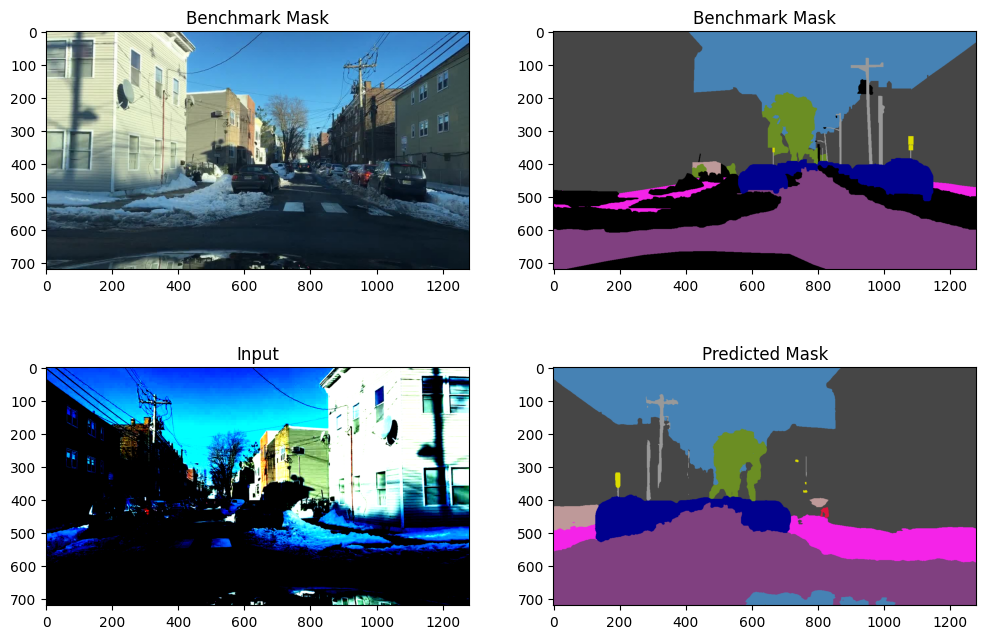

In [11]:
pred_img_np = (lbl_tensor.numpy()*255).astype(np.int8)
pred_img = Image.new('P', (pred_img_np.shape[1], pred_img_np.shape[0]))
palettes = get_palette("sem_seg")
pred_img.putpalette(palettes)
pred_img.putdata(pred_img_np.ravel().tolist())
# comb_img = Image.blend(image_origin, pred_img.convert("RGB"), alpha=0.5)

plt.figure(figsize=(12, 8))  

plt.subplot(2, 2, 1)  
plt.imshow(image_origin)  
plt.title('Benchmark Mask')  

plt.subplot(2, 2, 2)  
plt.imshow(color_lbl)  
plt.title('Benchmark Mask')  

plt.subplot(2, 2, 3)  
plt.imshow(image_tensor.squeeze().permute(1,2,0).detach().numpy())  
plt.title('Input')

pred_img_np = output.numpy()
pred_img = Image.new('P', (pred_img_np.shape[1], pred_img_np.shape[0]))
palettes = get_palette("sem_seg")
pred_img.putpalette(palettes)
pred_img.putdata(pred_img_np.ravel().tolist())
comb_img = Image.blend(image_origin, pred_img.convert("RGB"), alpha=0.5)

plt.subplot(2, 2, 4)  
plt.imshow(pred_img)  
plt.title('Predicted Mask')


# plt.subplot(1, 4, 4)  
# plt.imshow(comb_img)  
# plt.title('Combined Image')  

plt.savefig("ttt.jpg")
plt.show()

## check num of samples

In [27]:
concls_id = str(0)

In [33]:
conditionclass = handler.read(concls_id, Items.CONDITION_CLASS)

cond_list = conditionclass.conditions

def extract_attr(attr_dict:dict):
        return [attr_dict["weather"], attr_dict["scene"], attr_dict["timeofday"]]

def comb_attr(attr_lst):
    return "-".join(attr_lst)

def split_attr(attr_s:str):
     return attr_s.split('-')

train_record_lst = {}
with open(train_attr_file, 'r') as f:
    attr_data = json.load(f)
    for entry in attr_data:
        attr = extract_attr(entry['attributes'])
        if len(cond_list) == 0 or attr in cond_list:
            k = comb_attr(attr)
            train_record_lst[k] = train_record_lst.get(k,0) + 1

val_record_lst = {}
with open(val_attr_file, 'r') as f:
    attr_data = json.load(f)
    for entry in attr_data:
        attr = extract_attr(entry['attributes'])
        if len(cond_list) == 0 or attr in cond_list:
            k = comb_attr(attr)
            val_record_lst[k] = val_record_lst.get(k,0) + 1

table = PrettyTable()
table.field_names = ['weather', 'scene', 'timeofday', 'train_samples', 'val_samples']

v_all, v2_all = [], []
for k,v in train_record_lst.items():
    weather, scene, time = split_attr(k)
    v2 = val_record_lst.get(k,0)
    table.add_row([weather, scene, time, v, v2])
    v_all.append(v)
    v2_all.append(v2)
table.add_row(["all", "all", "all", sum(v_all), sum(v2_all)])
print(f"total train conditions: {len(train_record_lst)}")
print(f"total val conditions: {len(val_record_lst)}")

table.sortby = 'val_samples'
table.reversesort = True

print(table)


total train conditions: 44
total val conditions: 30
+---------------+-------------+-----------+---------------+-------------+
|    weather    |    scene    | timeofday | train_samples | val_samples |
+---------------+-------------+-----------+---------------+-------------+
|      all      |     all     |    all    |      7000     |     1000    |
|     clear     | city street |  daytime  |      1953     |     250     |
|    overcast   | city street |  daytime  |      1405     |     239     |
| partly cloudy | city street |  daytime  |      472      |      99     |
|     clear     |   highway   |  daytime  |      788      |      76     |
|     snowy     | city street |  daytime  |      398      |      74     |
|    overcast   |   highway   |  daytime  |      317      |      38     |
|    overcast   | residential |  daytime  |      138      |      35     |
|     clear     | residential |  daytime  |      168      |      27     |
|     rainy     | city street |  daytime  |      200      | 

## Show model graph

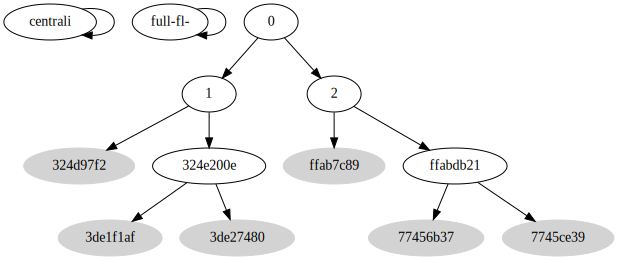

In [18]:
generate_graph(handler, ".")

## END

In [3]:
st = "aaabbbccc"
print(st[:-1])

aaabbbcc
